# Comparisons with MOSAiC SIMBA buoys

**Summary:** In this notebook, we produce comparisons of all-season monthly gridded ICESat-2 and CryoSat-2 sea ice thickness data with snow depth and sea ice thickness obtained from MOSAiC/SIMBA buoys in 2019-2020.

**Author**: Alek Petty

**Version history**: 
 - Version 2 (09/25/2025): updated with new MERRA-2 and ERA5 snow loading and some other tweaks. 
 - Version 1 (05/01/2025)
 

# Import notebook dependencies

In [17]:
import xarray as xr 
import pandas as pd
import numpy as np
import itertools
import pyproj 
from netCDF4 import Dataset
import scipy.interpolate 
from utils.read_data_utils import read_book_data, read_IS2SITMOGR4 # Helper function for reading the data from the bucket
from utils.plotting_utils import compute_gridcell_winter_means, interactiveArcticMaps, interactive_winter_mean_maps, interactive_winter_comparison_lineplot # Plotting
from scipy import stats
import datetime
# Plotting dependencies
import cartopy.crs as ccrs
from textwrap import wrap
import hvplot.pandas
import holoviews as hv
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from cartopy.mpl.geoaxes import GeoAxes
GeoAxes._pcolormesh_patched = Axes.pcolormesh # Helps avoid some weird issues with the polar projection 
%config InlineBackend.figure_format = 'retina'
import matplotlib as mpl

# Interpolating/smoothing packages 
from scipy.interpolate import griddata
from scipy.spatial import KDTree
from astropy.convolution import convolve
from astropy.convolution import Gaussian2DKernel

mpl.rcParams['figure.dpi'] = 200 # Sets figure size in the notebook

# Remove warnings to improve display
import warnings 
warnings.filterwarnings('ignore') 


In [18]:
# Set some plotting parameters
mpl.rcParams.update({
    "text.usetex": False,  # Use LaTeX for rendering
    "font.family": "sans-serif",
    'mathtext.fontset': 'stixsans',
    #'mathtext.default': 'regular',
    #"lines.linewidth": 1.,
    "font.size": 7,
    #"lines.alpha": 0.8,
    "axes.labelsize": 7,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "legend.fontsize": 7
})


mpl.rcParams['figure.dpi'] = 300


In [19]:
grid_size=100
ib_agg_str='mean'
extra='simba'
int_str='_int'

reanalysis = 'e5'
reanalysis_two = 'm2'

# Define the variables to compare
variables_ice = [
    'ice_thickness'+int_str,
    'ice_thickness_sm_'+reanalysis+int_str+'_apr', 
    'ice_thickness_sm_'+reanalysis_two+int_str+'_apr', 
    'ice_thickness_mw99r', 
    'ice_thickness_J22'+int_str, 
    'ice_thickness_cs2_ubris_apr',
    'ice_thickness_sm_'+reanalysis+int_str,
    'ice_thickness_sm_'+reanalysis_two+int_str,
    'ice_thickness_cs2_ubris'
]

# Define the variables to compare
variables_snow = [
    'snow_depth'+int_str, 
    'snow_depth_sm_'+reanalysis+int_str+'_apr', 
    'snow_depth_sm_'+reanalysis_two+int_str+'_apr', 
    'snow_depth_mw99r',
    'cs2is2_snow_depth',
    'snow_depth_sm_'+reanalysis+int_str,
    'snow_depth_sm_'+reanalysis_two+int_str
]

variables_all = variables_ice+variables_snow

In [20]:
# Load the all-season wrangled dataset
IS2_CS2_allseason = xr.open_dataset('./data/book_data_allseason_v1.nc')
print("Successfully loaded all-season wrangled dataset")

Successfully loaded all-season wrangled dataset


In [21]:
out_proj = 'EPSG:3411'
out_lons = IS2_CS2_allseason.longitude.values
out_lats = IS2_CS2_allseason.latitude.values

mapProj = pyproj.Proj("+init=" + out_proj)
xptsIS2, yptsIS2 = mapProj(out_lons, out_lats)

In [22]:
# Limit to MOSAiC/SIMBA time period
IS2_CS2_allseason = IS2_CS2_allseason.sel(time=slice('2019-10-01', '2020-06-30'))

In [23]:
# Create new variables with October-April time period filter
variables = ['snow_depth_sm_'+reanalysis+int_str, 'snow_depth_sm_'+reanalysis_two+int_str, 'ice_thickness_sm_'+reanalysis+int_str, 'ice_thickness_sm_'+reanalysis_two+int_str, 'ice_thickness_cs2_ubris']

for var in variables:
    # Create mask for October through April
    # Month values: October (10) through December (12) and January (1) through April (4)
    month_mask = (IS2_CS2_allseason.time.dt.month >= 10) | (IS2_CS2_allseason.time.dt.month <= 4)
    
    # Create new variable with '_apr' suffix
    new_var_name = f"{var}_apr"
    IS2_CS2_allseason[new_var_name] = IS2_CS2_allseason[var].where(month_mask)

In [24]:
# COARSEN TO MATCH 100 KM RESOLUTION OF IB
if grid_size==100:
    # First count valid values in each block
    valid_counts = IS2_CS2_allseason.notnull().coarsen(y=4, x=4, boundary='trim').sum()
    
    # Calculate means
    means = IS2_CS2_allseason.coarsen(y=4, x=4, boundary='trim').mean()
    
    # Mask means where count is less than minimum
    IS2_CS2_allseason = means.where(valid_counts >= 4)

IS2_CS2_allseason

<xarray.Dataset> Size: 19MB
Dimensions:                         (time: 9, y: 112, x: 76)
Coordinates:
  * time                            (time) datetime64[ns] 72B 2019-10-15 ... ...
  * x                               (x) float32 304B -3.8e+06 ... 3.7e+06
  * y                               (y) float32 448B 5.8e+06 ... -5.3e+06
    longitude                       (y, x) float32 34kB 168.2 167.5 ... -10.08
    latitude                        (y, x) float32 34kB 31.47 31.85 ... 34.85
Data variables: (12/58)
    crs                             (time) float64 72B nan nan nan ... nan nan
    ice_thickness_sm_e5             (time, y, x) float32 306kB nan nan ... nan
    ice_thickness_sm_m2             (time, y, x) float32 306kB nan nan ... nan
    ice_thickness_unc               (time, y, x) float32 306kB nan nan ... nan
    num_segments                    (time, y, x) float32 306kB nan nan ... nan
    mean_day_of_month               (time, y, x) float32 306kB nan nan ... nan
    ...                              ...
    cs2is2_snow_depth               (time, y, x) float64 613kB nan nan ... nan
    snow_depth_sm_e5_int_apr        (time, y, x) float32 306kB nan nan ... nan
    snow_depth_sm_m2_int_apr        (time, y, x) float32 306kB nan nan ... nan
    ice_thickness_sm_e5_int_apr     (time, y, x) float32 306kB nan nan ... nan
    ice_thickness_sm_m2_int_apr     (time, y, x) float32 306kB nan nan ... nan
    ice_thickness_cs2_ubris_apr     (time, y, x) float64 613kB 0.0 0.0 ... nan
Attributes:
    contact:      Alek Petty (akpetty@umd.edu)
    description:  Aggregated IS2SITMOGR4 summer V1 dataset.
    history:      Created 23/07/25

In [25]:
# Open SIMBA NetCDF file
file_path = '/Users/akpetty/Data/IS2-obs-comparison-data/simba_snow_ice_mosaic_on_is2_grid_'+str(grid_size)+'km.nc'
simba_data = xr.open_dataset(file_path)
simba_data = simba_data.rename({'date': 'time'})
simba_data = simba_data.transpose('y', 'x', 'time')

print(simba_data)

<xarray.Dataset> Size: 37MB
Dimensions:                   (x: 76, y: 112, time: 269)
Coordinates:
    lon                       (y, x) float32 34kB ...
    lat                       (y, x) float32 34kB ...
  * x                         (x) float32 304B -3.838e+06 ... 3.662e+06
  * y                         (y) float32 448B 5.838e+06 ... -5.262e+06
  * time                      (time) datetime64[ns] 2kB 2019-10-05 ... 2020-0...
    crs                       int32 4B ...
Data variables:
    sea_ice_thickness_mean    (y, x, time) float32 9MB ...
    sea_ice_thickness_median  (y, x, time) float32 9MB ...
    snow_thickness_mean       (y, x, time) float32 9MB ...
    snow_thickness_median     (y, x, time) float32 9MB ...


In [26]:
simba_data_monthly = simba_data.resample(time='MS').mean()
# Adjust time to middle (15th) of the month for plotting purposes (generally time defaults to the start of the month)
simba_data_monthly['time'] = simba_data_monthly['time'] + pd.Timedelta(days=14)


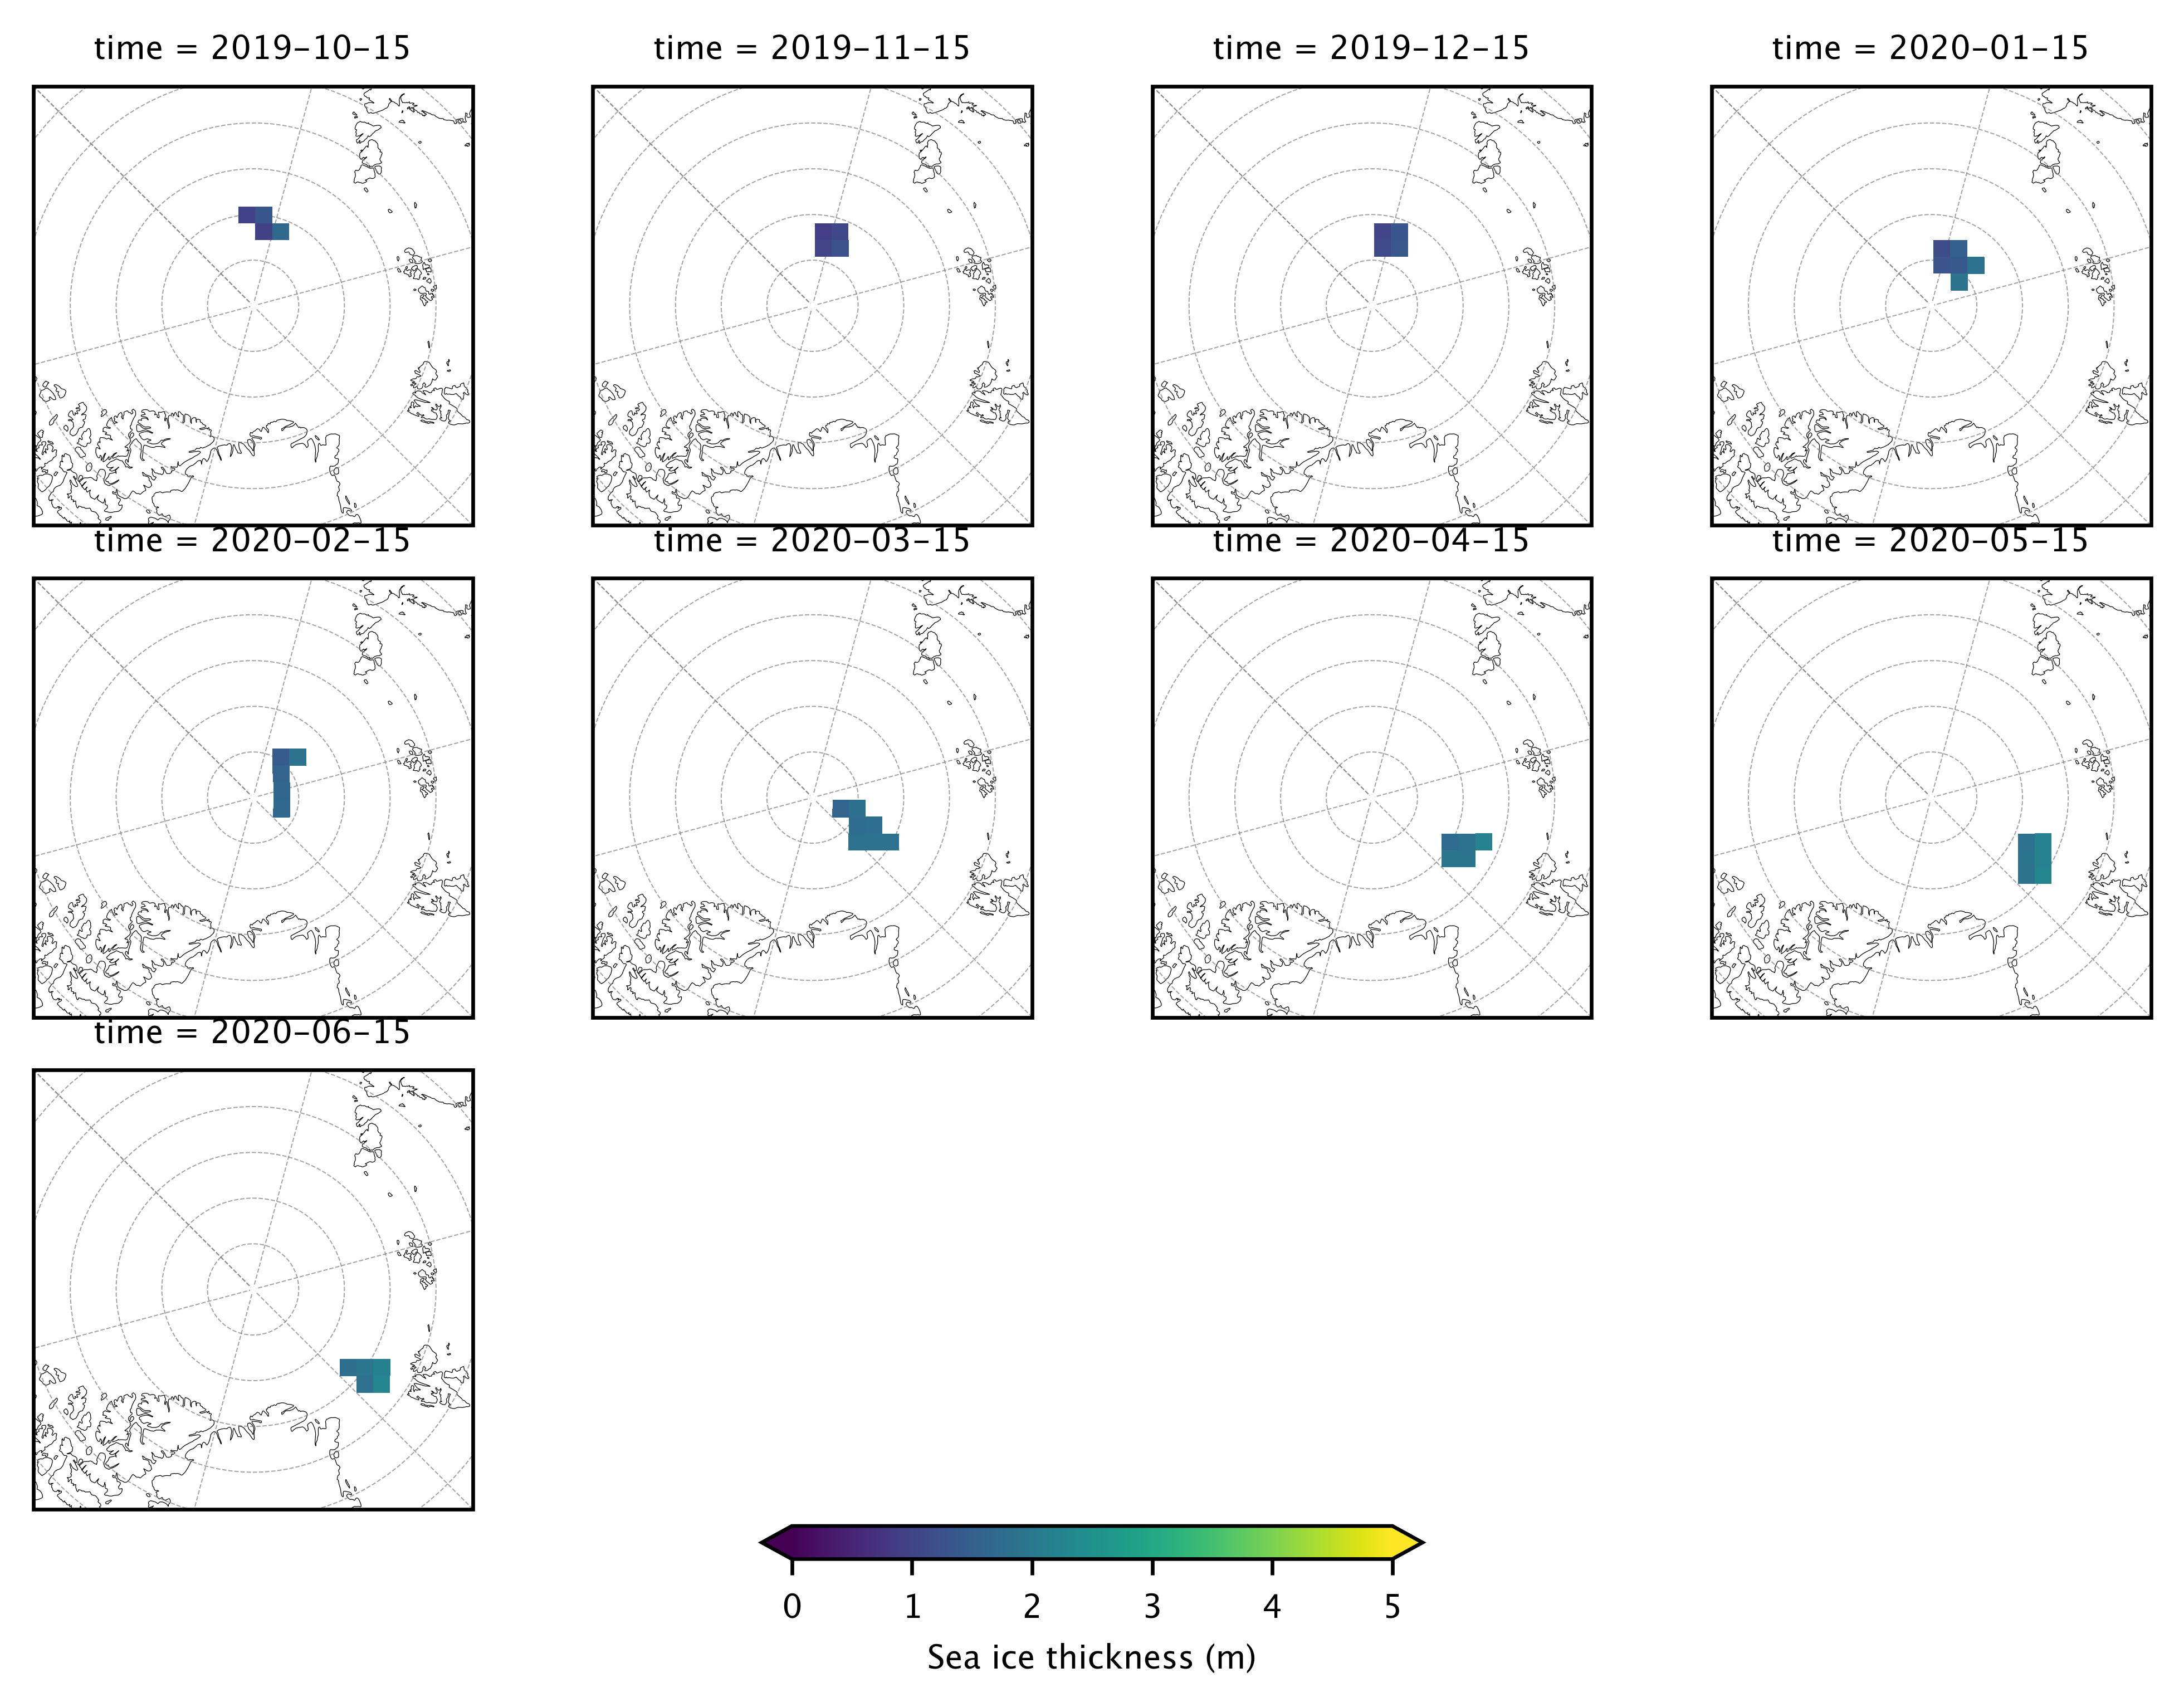

In [27]:

fig_width=6.8
fig_height=5.4

im1 = simba_data_monthly.sea_ice_thickness_mean.plot(x="lon", y="lat", col='time', transform=ccrs.PlateCarree(), 
                       cmap="viridis", zorder=3, add_labels=False, col_wrap=4,
                       subplot_kws={'projection':ccrs.NorthPolarStereo(central_longitude=-45)},
                       cbar_kwargs={'pad':0.01,'shrink': 0.3,'extend':'both', 
                                  'label':'Sea ice thickness (m)', 'location':'bottom'},
                       vmin=0, vmax=5,
                       figsize=(fig_width, fig_height))


# Add map features to all subplots
i=0
for i, ax in enumerate(im1.axes.flatten()):
    ax.coastlines(linewidth=0.15, color='black', zorder=2)
    #ax.add_feature(cfeature.LAND, color='0.95', zorder=1)
    ax.gridlines(draw_labels=False, linewidth=0.25, color='gray', alpha=0.7, linestyle='--', zorder=3)
    ax.set_extent([-179, 179, 78, 90], crs=ccrs.
    PlateCarree())
    #ax.text(0.02, 0.93, panel_letters[i], transform=ax.transAxes, fontsize=7, va='bottom', ha='left')
    #ax.set_title('', fontsize=8)
    i+=1

#plt.subplots_adjust(wspace=0.01) 
#plt.savefig('./figs/maps_summer_thickness_comparison.png', dpi=300, facecolor="white")
plt.show()
plt.close()

In [28]:
times = simba_data_monthly.time.values
# Define a reference date (adjust as needed)
reference_date = np.datetime64('2019-10-01')
# Convert times to days since reference date
days_since_reference = (times - reference_date).astype('timedelta64[D]').astype(int)

shape = (len(times), simba_data_monthly.sea_ice_thickness_mean.y.shape[0], simba_data_monthly.sea_ice_thickness_mean.x.shape[0]) 
month_time = np.empty(shape)
month_time.fill(np.nan)

for i in range(len(times)):
    valid_cells = ~np.isnan(simba_data_monthly['sea_ice_thickness_mean']).isel(time=i).values
    month_time[i][valid_cells] = days_since_reference[i]
mean_simba_time = np.nanmean(month_time, axis=0)



In [29]:
# Plot months to check all looks right.
times

array(['2019-10-15T00:00:00.000000000', '2019-11-15T00:00:00.000000000',
       '2019-12-15T00:00:00.000000000', '2020-01-15T00:00:00.000000000',
       '2020-02-15T00:00:00.000000000', '2020-03-15T00:00:00.000000000',
       '2020-04-15T00:00:00.000000000', '2020-05-15T00:00:00.000000000',
       '2020-06-15T00:00:00.000000000'], dtype='datetime64[ns]')

In [30]:

reference_date = np.datetime64('2019-10-01')  # Example reference date

# Initialize a dictionary to store validation results
validation_results = {}

# Calculate statistics and generate scatter plots for each variable
for var in variables_ice:
    # Calculate statistics
    IS2_var = IS2_CS2_allseason[var]
    IB_var = simba_data_monthly['sea_ice_thickness_mean']
    IB_time = simba_data_monthly['time']
    # Initialize lists to store the stacked points
    IB_comps_list = []
    IS2_comps_list = []
    IB_time_list = []
    # Loop through the time dimension
    for t in range(IS2_var.sizes['time']):
        print('IS2 time', t, var)
        IS2_var_time = IS2_var.isel(time=t)
        IB_var_time = IB_var.isel(time=t)
        #print('IB time', IB_var_time)
        valid_mask = ~np.isnan(IS2_var_time.values) & ~np.isnan(IB_var_time.values)
        IB_comps_list.append(IB_var_time.where(valid_mask).values.flatten()[~np.isnan(IB_var_time.where(valid_mask).values.flatten())])
        IS2_comps_list.append(IS2_var_time.where(valid_mask).values.flatten()[~np.isnan(IS2_var_time.where(valid_mask).values.flatten())])

        days_since_array = (IB_time.isel(time=t).values - reference_date).astype('timedelta64[D]').astype(int)
        print(days_since_array)

        IB_time_list.append([days_since_array]*len(IB_var_time.where(valid_mask).values.flatten()[~np.isnan(IB_var_time.where(valid_mask).values.flatten())]))
    # Stack the points together
    IB_comps = np.concatenate(IB_comps_list)
    IS2_comps = np.concatenate(IS2_comps_list)
    IB_time = np.concatenate(IB_time_list)
    # Correlation Coeff
    correlation = '%.02f' % (np.corrcoef(IS2_comps, IB_comps)[0, 1])
    # Calculate mean bias
    mean_bias = '%.02f' % (np.mean(IS2_comps - IB_comps))
    # Calculate standard dev of differences
    std_dev = '%.02f' % (np.std(IB_comps - IS2_comps))
    # Calculate RMSE    
    rmse = '%.02f' % (np.sqrt(np.mean((IS2_comps - IB_comps) ** 2)))
    
    # Store results
    validation_results[var] = {
        'r_str': correlation, 'mb_str': mean_bias, 'sd_str': std_dev, 'rmse': rmse, 
        'IB_comps': IB_comps, 'IS2_comps': IS2_comps,'IB_time': IB_time
    }

# Print validation results
print(validation_results)

IS2 time 0 ice_thickness_int
14
IS2 time 1 ice_thickness_int
45
IS2 time 2 ice_thickness_int
75
IS2 time 3 ice_thickness_int
106
IS2 time 4 ice_thickness_int
137
IS2 time 5 ice_thickness_int
166
IS2 time 6 ice_thickness_int
197
IS2 time 7 ice_thickness_int
227
IS2 time 8 ice_thickness_int
258
IS2 time 0 ice_thickness_sm_e5_int_apr
14
IS2 time 1 ice_thickness_sm_e5_int_apr
45
IS2 time 2 ice_thickness_sm_e5_int_apr
75
IS2 time 3 ice_thickness_sm_e5_int_apr
106
IS2 time 4 ice_thickness_sm_e5_int_apr
137
IS2 time 5 ice_thickness_sm_e5_int_apr
166
IS2 time 6 ice_thickness_sm_e5_int_apr
197
IS2 time 7 ice_thickness_sm_e5_int_apr
227
IS2 time 8 ice_thickness_sm_e5_int_apr
258
IS2 time 0 ice_thickness_sm_m2_int_apr
14
IS2 time 1 ice_thickness_sm_m2_int_apr
45
IS2 time 2 ice_thickness_sm_m2_int_apr
75
IS2 time 3 ice_thickness_sm_m2_int_apr
106
IS2 time 4 ice_thickness_sm_m2_int_apr
137
IS2 time 5 ice_thickness_sm_m2_int_apr
166
IS2 time 6 ice_thickness_sm_m2_int_apr
197
IS2 time 7 ice_thickness

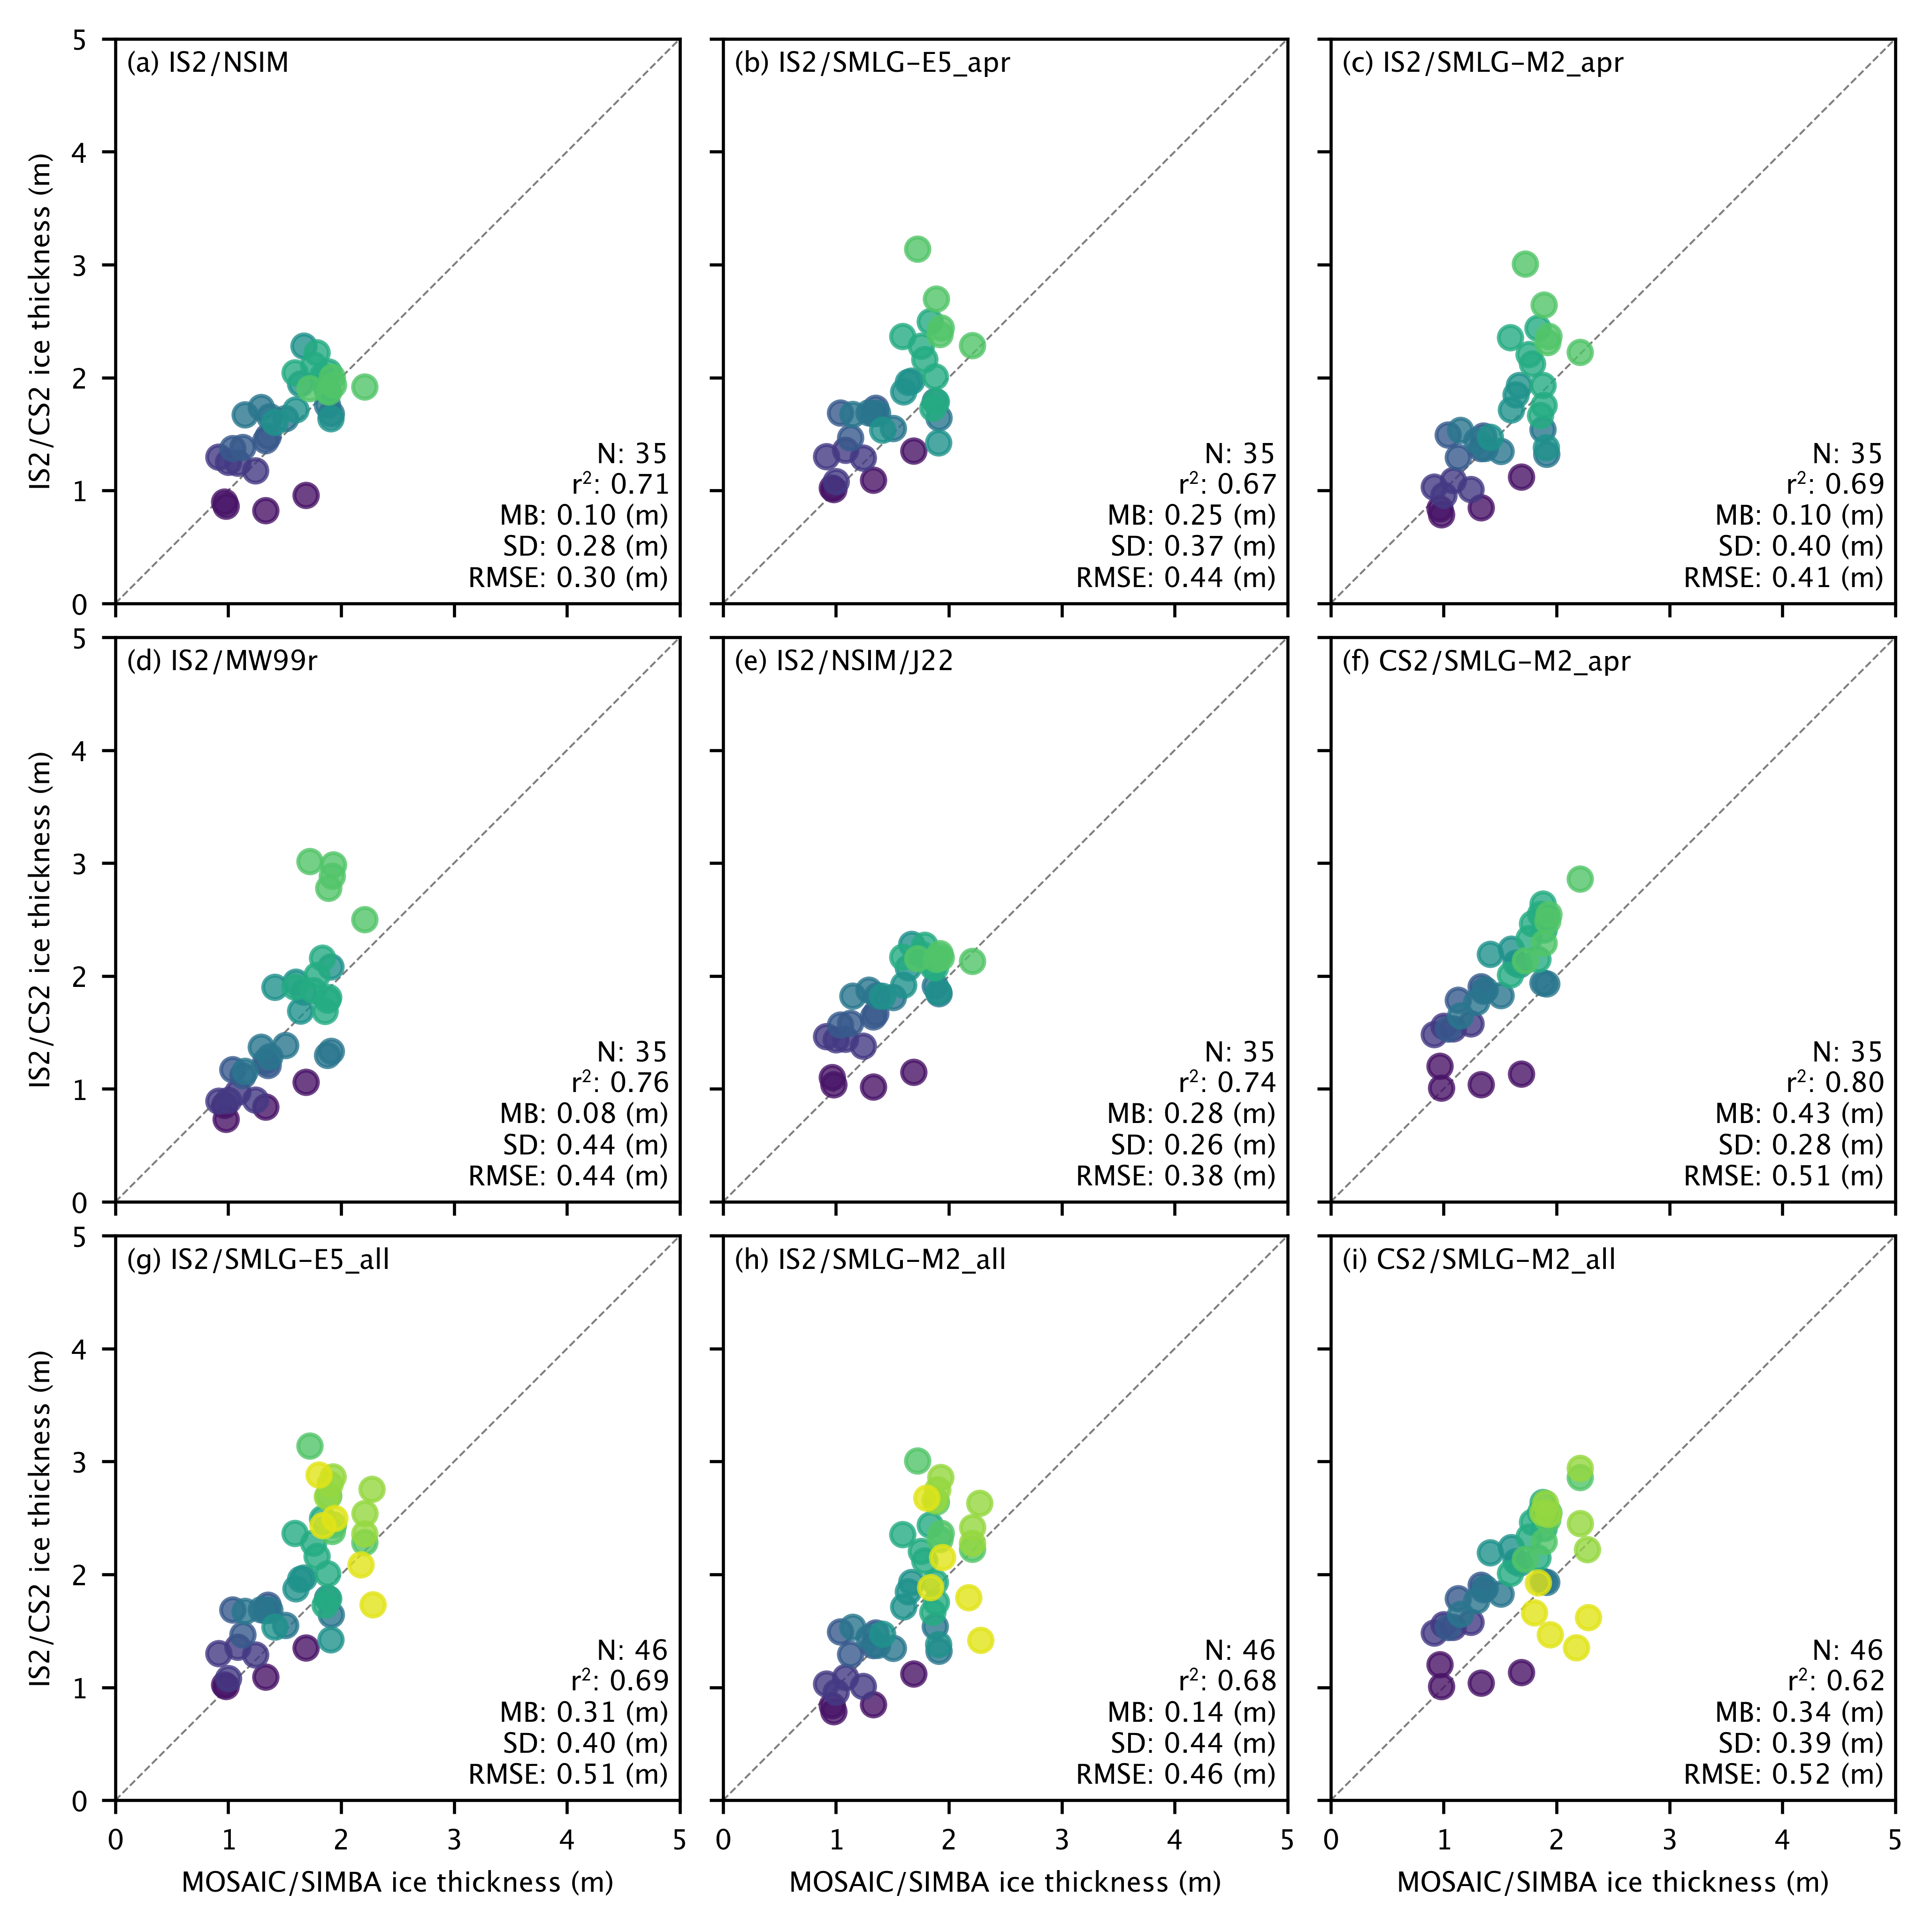

In [31]:
# Create figure with subplots
fig = plt.figure(figsize=(6.8, 6.8))  # Square figure for 3x3 grid
gs = fig.add_gridspec(3, 3, hspace=0.06, wspace=0.04)  # Changed to 3x3 grid

axes = []
for i in range(3):
    for j in range(3):
        ax = fig.add_subplot(gs[i, j])
        axes.append(ax)


panel_labels = ['(a) IS2/NSIM', '(b) IS2/SMLG-'+reanalysis.capitalize()+'_apr', '(c) IS2/SMLG-'+reanalysis_two.capitalize()+'_apr', '(d) IS2/MW99r', '(e) IS2/NSIM/J22', '(f) CS2/SMLG-M2_apr', '(g) IS2/SMLG-'+reanalysis.capitalize()+'_all', '(h) IS2/SMLG-'+reanalysis_two.capitalize()+'_all', '(i) CS2/SMLG-M2_all', '(j)']

# Process the other subplots
for i, option in enumerate(variables_ice):
    if i < 10:  # Process first 8 variables
        ax = axes[i]
        
        im = ax.scatter(validation_results[option]['IB_comps'], validation_results[option]['IS2_comps'], 
                       c=validation_results[option]['IB_time'], alpha=0.8, vmin=0, vmax=270)

        # Retrieve validation results for the current option
        r_str = validation_results[option]['r_str']
        mb_str = validation_results[option]['mb_str']
        sd_str = validation_results[option]['sd_str']
        n_str = str(len(validation_results[option]['IS2_comps']))
        rmse = validation_results[option]['rmse']

        # Annotate the plot with statistics
        ax.annotate(f"N: {n_str}\nr$^2$: {r_str}\nMB: {mb_str} (m)\nSD: {sd_str} (m)\nRMSE: {rmse} (m)", 
                    color='k', xy=(0.98, 0.02), xycoords='axes fraction', 
                    horizontalalignment='right', verticalalignment='bottom')

        # Combine panel label with option label
        ax.annotate(f"{panel_labels[i]} ", xy=(0.02, 0.98), 
                    xycoords='axes fraction', horizontalalignment='left', verticalalignment='top')

        # Set x and y labels only for the leftmost and bottom plots
        if i == 0:
            ax.legend(frameon=False, loc="upper right")
        if i % 3 == 0:  # First column
            ax.set_ylabel('IS2/CS2 ice thickness (m)')
        else:
            ax.set_yticklabels('')
        if i >= 6:  # Bottom row
            ax.set_xlabel('MOSAIC/SIMBA ice thickness (m)')
        else:
            ax.set_xlabel('')
            ax.set_xticklabels('')

        ax.set_xlim([0, 5])
        ax.set_ylim([0, 5])
        lims = [
            np.min([ax.get_xlim(), ax.get_ylim()]),
            np.max([ax.get_xlim(), ax.get_ylim()]),
        ]
        ax.plot(lims, lims, 'k--', linewidth=0.5, alpha=0.5, zorder=0)
        ax.set_aspect('equal')
        ax.set_xlim(lims)
        ax.set_ylim(lims)

plt.subplots_adjust(left=0.05, right=0.99, top=0.98, bottom=0.06)

plt.savefig('./figs/MOSAIC_scatter_inccs2_'+ib_agg_str+'_'+str(grid_size)+'km_map'+extra+'_v2.pdf', dpi=300)
plt.show()

In [32]:


# Initialize a dictionary to store validation results
validation_results_snow = {}

# Calculate statistics and generate scatter plots for each variable
for var in variables_snow:
    # Calculate statistics
    IS2_var = IS2_CS2_allseason[var]
    IB_var = simba_data_monthly['snow_thickness_mean']
    IB_time = simba_data_monthly['time']
    # Initialize lists to store the stacked points
    IB_comps_list = []
    IS2_comps_list = []
    IB_time_list = []
    # Loop through the time dimension
    for t in range(IS2_var.sizes['time']):
        IS2_var_time = IS2_var.isel(time=t)
        IB_var_time = IB_var.isel(time=t)
        
        valid_mask = ~np.isnan(IS2_var_time.values) & ~np.isnan(IB_var_time.values)
        IB_comps_list.append(IB_var_time.where(valid_mask).values.flatten()[~np.isnan(IB_var_time.where(valid_mask).values.flatten())])
        IS2_comps_list.append(IS2_var_time.where(valid_mask).values.flatten()[~np.isnan(IS2_var_time.where(valid_mask).values.flatten())])
        
        days_since_array = (IB_time.isel(time=t).values - reference_date).astype('timedelta64[D]').astype(int)
        print(days_since_array)

        IB_time_list.append([days_since_array]*len(IB_var_time.where(valid_mask).values.flatten()[~np.isnan(IB_var_time.where(valid_mask).values.flatten())]))
    
    # Stack the points together
    IB_comps = np.concatenate(IB_comps_list)
    IS2_comps = np.concatenate(IS2_comps_list)
    IB_time = np.concatenate(IB_time_list)
    # Correlation Coeff
    correlation = '%.02f' % (np.corrcoef(IS2_comps, IB_comps)[0, 1])
    # Calculate mean bias
    mean_bias = '%.02f' % (np.mean(IS2_comps - IB_comps))
    # Calculate standard dev of differences
    std_dev = '%.02f' % (np.std(IS2_comps - IB_comps))
    # Calculate RMSE    
    rmse = '%.02f' % (np.sqrt(np.mean((IS2_comps - IB_comps) ** 2)))
    
    # Store results
    validation_results_snow[var] = {
        'r_str': correlation, 'mb_str': mean_bias, 'sd_str': std_dev, 'rmse': rmse, 'IB_comps': IB_comps, 'IS2_comps': IS2_comps, 'IB_time': IB_time
    }

# Print validation results
print(validation_results_snow)

14
45
75
106
137
166
197
227
258
14
45
75
106
137
166
197
227
258
14
45
75
106
137
166
197
227
258
14
45
75
106
137
166
197
227
258
14
45
75
106
137
166
197
227
258
14
45
75
106
137
166
197
227
258
14
45
75
106
137
166
197
227
258
{'snow_depth_int': {'r_str': '0.43', 'mb_str': '0.02', 'sd_str': '0.06', 'rmse': '0.06', 'IB_comps': array([0.13708332, 0.1619679 , 0.14593333, 0.21      , 0.15358159,
       0.19090185, 0.14571428, 0.15049998, 0.16987641, 0.21794605,
       0.16413799, 0.18978116, 0.18664286, 0.21845455, 0.18083334,
       0.20213781, 0.245     , 0.18666667, 0.21199134, 0.31      ,
       0.19415672, 0.22210054, 0.19656365, 0.20855123, 0.22820054,
       0.20411025, 0.22723332, 0.21000001, 0.18589242, 0.22254443,
       0.17655203, 0.22176191, 0.21      , 0.17999999, 0.2027704 ],
      dtype=float32), 'IS2_comps': array([0.127375  , 0.146125  , 0.14250001, 0.148625  , 0.1441875 ,
       0.16625   , 0.1535625 , 0.1621875 , 0.1825625 , 0.1920625 ,
       0.181875  , 0.19000001

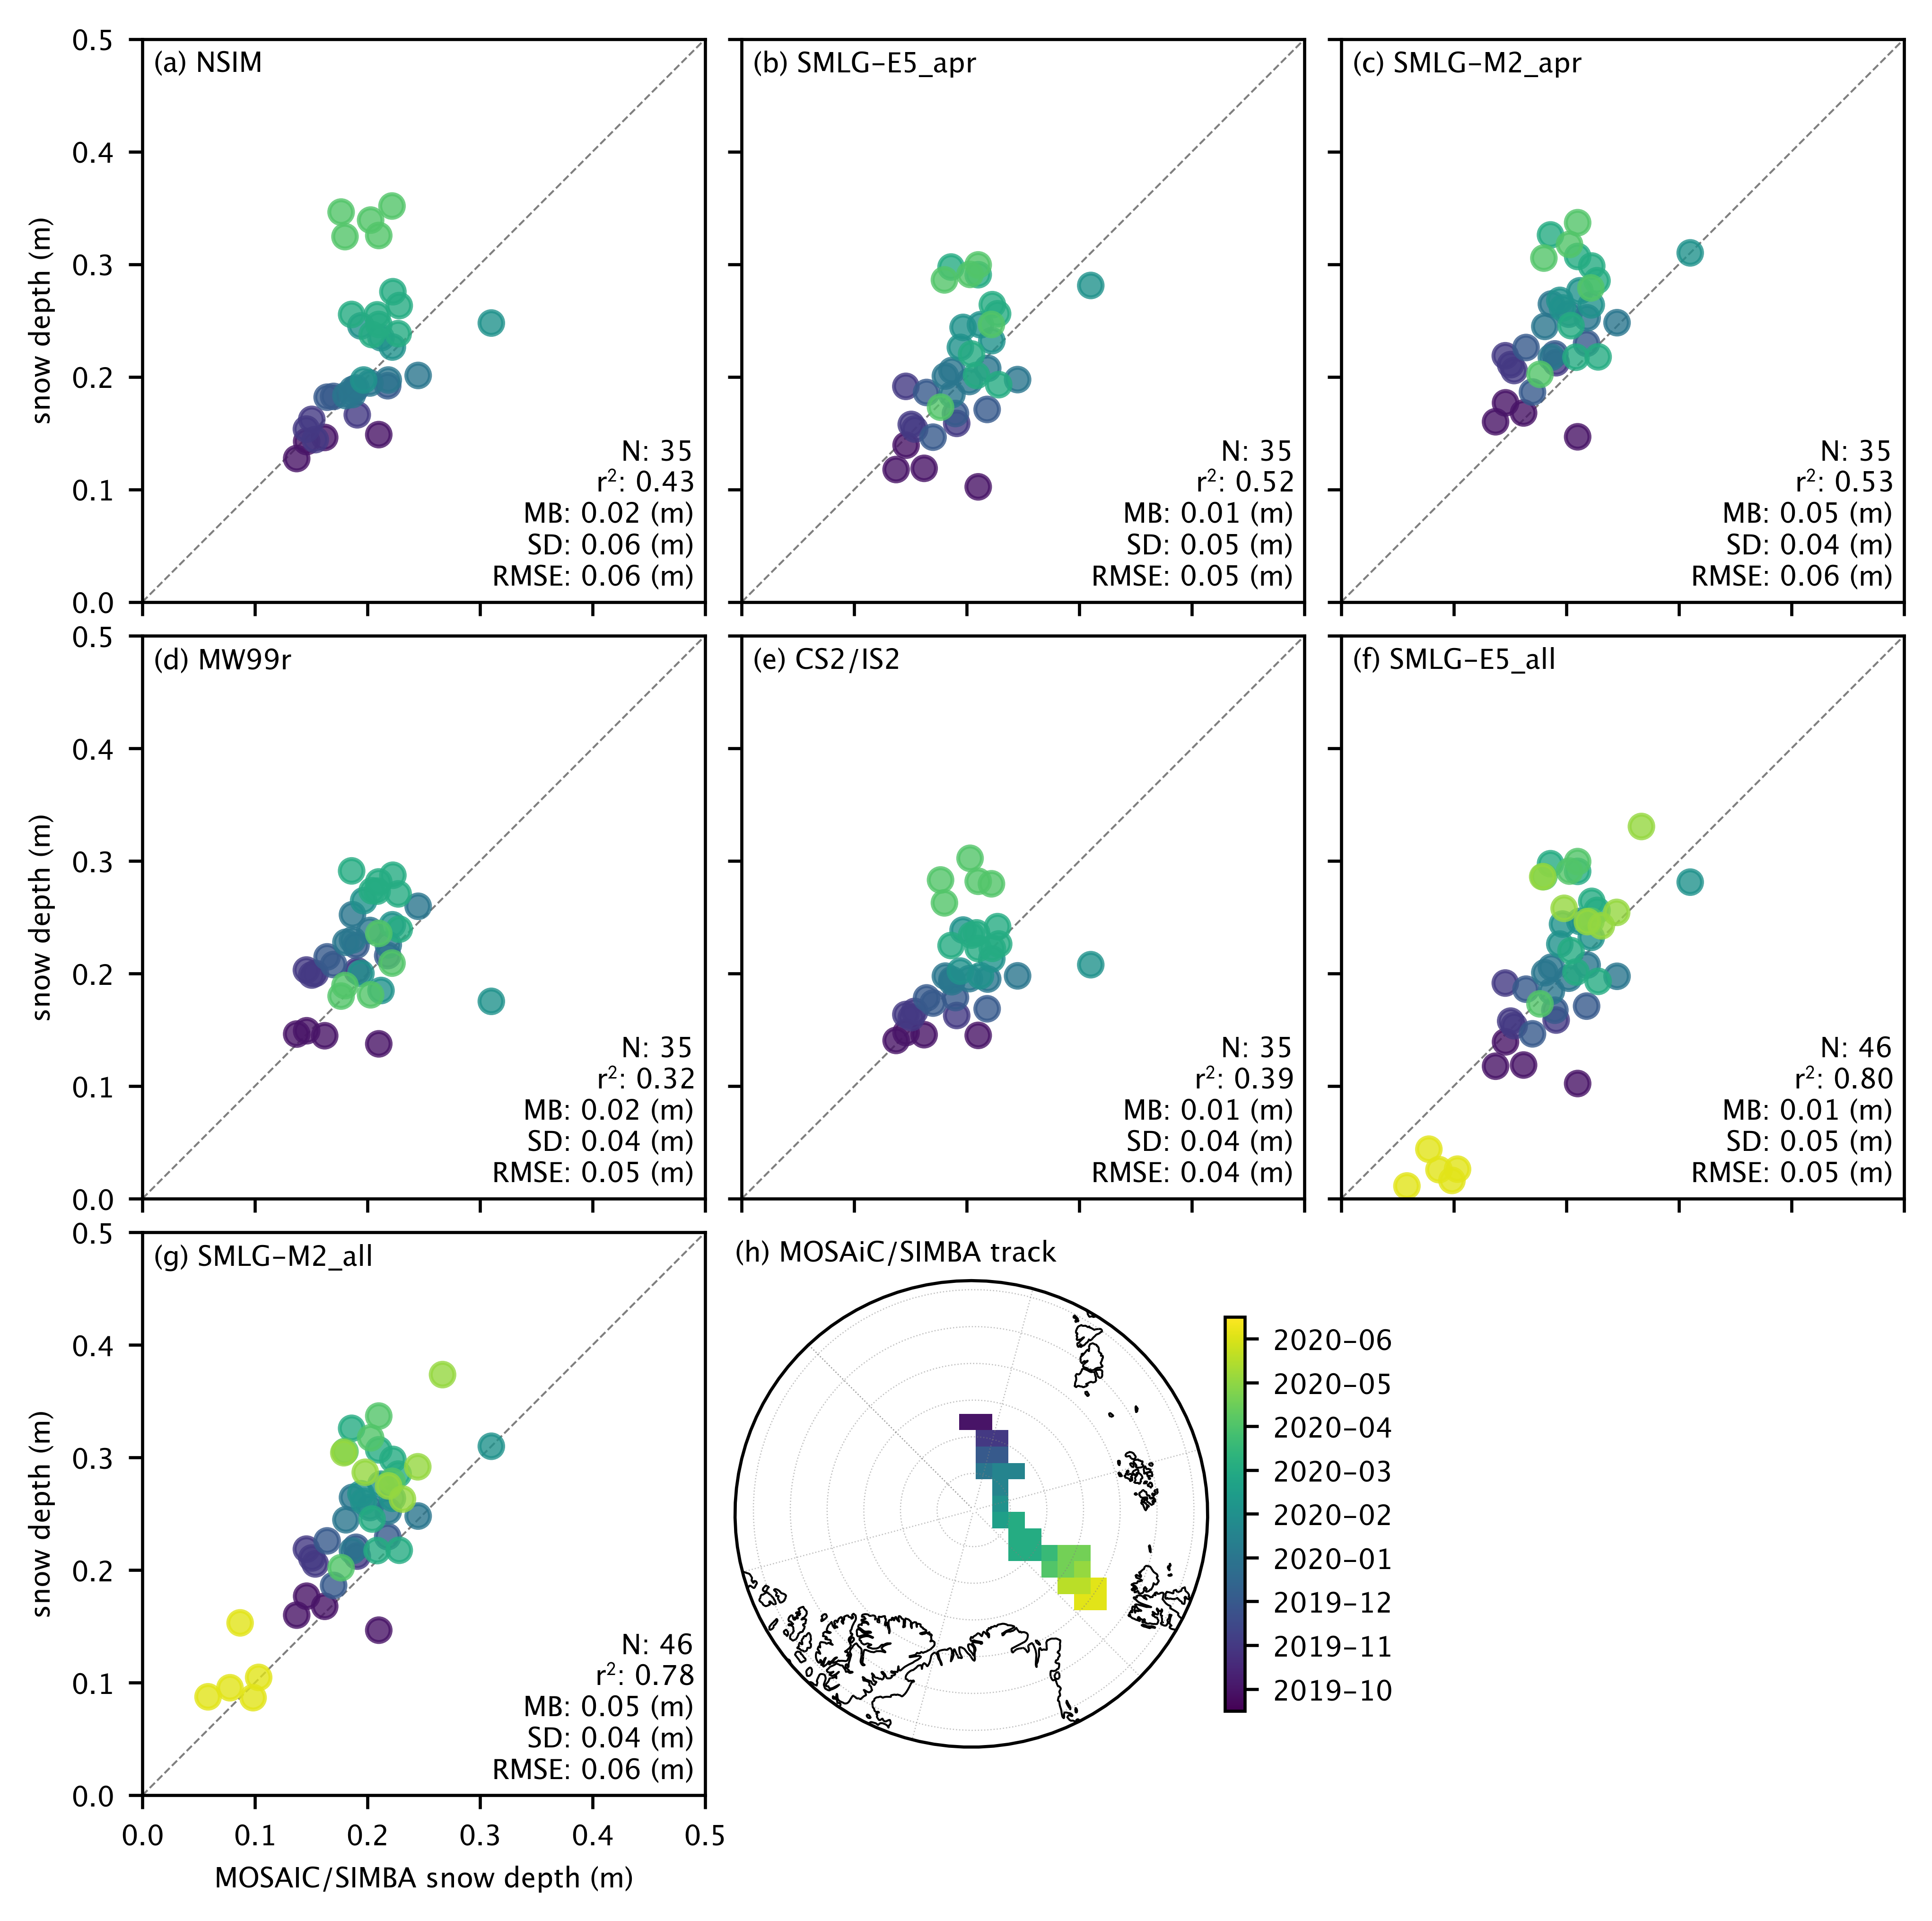

In [33]:

# Update snow_labels to include all 5 variables
snow_labels=['NSIM', 'SMLG-'+reanalysis.capitalize()+'_apr', 'SMLG-'+reanalysis_two.capitalize()+'_apr', 'MW99r', 'CS2/IS2', 'SMLG-'+reanalysis.capitalize()+'_all', 'SMLG-'+reanalysis_two.capitalize()+'_all', 'MOSAiC/SIMBA track']  # Adjust these labels as needed

#axes = axes.flatten()  # Flatten the 2D array of axes for easy iteration
panel_labels = ['(a)', '(b)', '(c)', '(d)', '(e)', '(f)', '(g)', '(h)']  # Updated panel labels


# Figure
fig = plt.figure(figsize=(6.8, 6.8))  # Square figure for 3x3 grid
gs = fig.add_gridspec(3, 3, hspace=0.06, wspace=0.04)  # Changed to 3x3 grid

axes = []
for i in range(3):
    for j in range(3):
        if i == 2 and j == 1:  # Move map to bottom right
            # Create the cartopy map in the last position
            ax = fig.add_subplot(gs[i, j], projection=ccrs.NorthPolarStereo(central_longitude=-45))
        else:
            ax = fig.add_subplot(gs[i, j])
        axes.append(ax)
        

# Configure the cartopy map in the last subplot
map_ax = axes[7]  # Changed to last position (3x3=9, so index 8)
map_ax.set_extent([-180, 180, 77, 90], crs=ccrs.PlateCarree())
map_ax.coastlines(resolution='50m', color='black', linewidth=0.5)
map_ax.gridlines(draw_labels=False, linewidth=0.3, color='gray', alpha=0.5, linestyle=':')

# Add a circular boundary for the polar plot
theta = np.linspace(0, 2*np.pi, 100)
center, radius = [0.5, 0.5], 0.5
verts = np.vstack([np.sin(theta), np.cos(theta)]).T
circle = mpl.path.Path(verts * radius + center)
map_ax.set_boundary(circle, transform=map_ax.transAxes)

# Plot the sea ice thickness data
im = map_ax.pcolormesh(
    simba_data_monthly.x, 
    simba_data_monthly.y, 
    mean_simba_time, 
    transform=ccrs.NorthPolarStereo(central_longitude=-45),
    vmin=0,
    vmax=270,
    cmap='viridis',
)

cbar = map_ax.figure.colorbar(im, ax=map_ax, orientation='vertical', 
                              pad=0.03, shrink=0.7)
# Create dates using pandas
start_date = pd.Timestamp('2019-10-01')
days = np.array([15, 45, 75, 105, 135, 165, 195, 225, 255])
dates = [start_date + pd.Timedelta(days=int(d)) for d in days]
labels = [d.strftime('%Y-%m') for d in dates]

# Set new ticks and labels
cbar.set_ticks(days)
cbar.set_ticklabels(labels)

# Add panel label for map
map_ax.annotate(f"{panel_labels[7]} MOSAiC/SIMBA track", xy=(0.0, 1.03), 
                xycoords='axes fraction', 
                horizontalalignment='left', 
                verticalalignment='bottom')

axes[8].set_visible(False)  # Hide the 9th panel (bottom right)

for i, option in enumerate(variables_snow):
    ax = axes[i]
    
    ax.scatter(validation_results_snow[option]['IB_comps'], 
              validation_results_snow[option]['IS2_comps'], 
              c=validation_results_snow[option]['IB_time'], 
              alpha=0.8, vmin=0, vmax=270)

    # Retrieve validation results for the current option
    r_str = validation_results_snow[option]['r_str']
    mb_str = validation_results_snow[option]['mb_str']
    sd_str = validation_results_snow[option]['sd_str']
    n_str = str(len(validation_results_snow[option]['IS2_comps']))
    rmse = validation_results_snow[option]['rmse']

    # Annotate the plot with statistics
    ax.annotate(f"N: {n_str}\nr$^2$: {r_str}\nMB: {mb_str} (m)\nSD: {sd_str} (m)\nRMSE: {rmse} (m)", 
                color='k', xy=(0.98, 0.02), xycoords='axes fraction', 
                horizontalalignment='right', verticalalignment='bottom')

    # Combine panel label with option label
    ax.annotate(f"{panel_labels[i]} "+snow_labels[i], xy=(0.02, 0.98), 
                xycoords='axes fraction', horizontalalignment='left', 
                verticalalignment='top')

    # Set x and y labels
    if i == 0:
        ax.legend(frameon=False, loc="upper right")
    if i in [0, 3, 6]:  # Left column
        ax.set_ylabel('snow depth (m)')
    else:
        ax.set_yticklabels('')
    if i in [6]:  # Bottom row
        ax.set_xlabel('MOSAIC/SIMBA snow depth (m)')
    else:
        ax.set_xlabel('')
        ax.set_xticklabels('')

    ax.set_xlim([0, 0.5])
    ax.set_ylim([0, 0.5])
    lims = [
        np.min([ax.get_xlim(), ax.get_ylim()]),
        np.max([ax.get_xlim(), ax.get_ylim()]),
    ]
    ax.plot(lims, lims, 'k--', linewidth=0.5, alpha=0.5, zorder=0)
    ax.set_aspect('equal')
    ax.set_xlim(lims)
    ax.set_ylim(lims)


plt.subplots_adjust(left=0.06, right=0.98, top=0.98, bottom=0.07)

plt.savefig('./figs/MOSAIC_scatter_snow_inccs2_'+ib_agg_str+'_'+str(grid_size)+'km'+extra+'_v2.pdf', dpi=300)
plt.show()